# 作业1

**姓名：** 杨希渊

**学号：** 524531910015

## 作业要求
- 完成所有的TODO，注意**不要有所遗漏**。问题4为附加题。
- 提交时请上传填写完的.ipynb文件，完成运行，确保存在输出结果。
- 如果有特殊的包需要导入的话，请附上一个文档说明理由和如何导入。
---
- **问题 1：赌徒问题 (40 分)** 正确实现 Value Iteration。
- **问题 2：有风网格世界 (40 分)** 正确实现 Sarsa 更新公式。
- **问题 3：Double DQN (20 分)** 正确计算 Target 值。
- **问题 4：Dueling DQN (0 分)** 附加题，答对了没奖励，答错了 / 不答没惩罚。

## 问题 1：赌徒问题

一个赌徒对掷硬币的游戏进行下注。如果硬币正面朝上，他将赢得押在这一掷上的所有赌注， 如果是反面朝上，他将输掉所押的赌注。如果赌徒赢得100美元或者输光了钱那么游戏结束。 每一次掷硬币，赌徒要决定押多少钱，这些钱必须是整数美元。 这个问题可以被建模为一个无衰减，回合式的有限MDP。 状态是赌徒的资本，$s\in \{1,2,\dots,99\}$， 动作是押注多少，$a\in \{0,1,\dots,\min(s,100-s)\}$。 赌徒达到目标时奖励是+1，其他转移过程都为0。状态价值函数给出了从每个状态出发能够赢得的概率。 策略是从资本多少到押注的一个映射。最优策略最大化达到目标的概率。 $p_h$ 代表硬币正面朝上的概率。如果 $p_h$ 知道了，那么整个问题都清楚了，并且可以被解决，比如用价值迭代方法。 图4.3展示出了价值函数经过成功的价值迭代更新后的变化，并且找到了 $p_h=0.4$ 情况下最终的策略。 这个策略是最优的，但不是唯一的。实际上，有很多最优策略，都取决于相对于最优价值函数选取的argmax动作。

<div align="center">
    <img src="images/capital.png" width="50%">
</div>

实现赌徒问题的价值迭代算法并且求解 $p_h=0.25$ 和 $p_h=0.55$ 的情况。 在编程的时候，设置两个对应于终止状态资本剩余为0和100情况的虚拟状态可能会比较方便，分别赋予0和1。 像下图那样用图展示出你的结果。随着 $\theta\leftarrow 0$ 你的结果是否稳定？

In [ ]:
import numpy as np
np.bool8 = np.bool_
import matplotlib.pyplot as plt


def train(ph, Theta=0.000001):
    V = [0]*101 # 0 to 100
    # Initialize V arbitrarily (e.g. random) except V[0]=0 and V[100]=1
    for i in range(1, 100):
        V[i] = np.random.random()
    V[0] = 0
    V[100] = 1
    
    pi = [0]*101
    counter = 1
    
    while True:
        Delta = 0
        for s in range(1, 100):  # for each state 1-99
            old_v = V[s]
            
            # Search for best action
            action_values = []
            # Valid bets: 1 to min(s, 100-s)
            possible_actions = range(1, min(s, 100 - s) + 1)
            
            for a in possible_actions:
                # Calculate value for action a
                # v_a = p_h * V[next_win] + (1 - p_h) * V[next_loss]
                ########################################
                # Programming 1: 计算Value Iteration中动作价值
                ########################################
                # 如果赢得赌注，转移到状态 s+a
                # 如果输掉赌注，转移到状态 s-a
                # 只有达到100时才有奖励+1，其他情况奖励为0
                win_reward = 1 if (s + a) == 100 else 0
                lose_reward = 0 
                
                # 计算动作价值
                v_a = ph * (win_reward + V[s + a]) + (1 - ph) * (lose_reward + V[s - a])
                ########################################
                ## End of Programming 1
                ########################################
                action_values.append(v_a)
            
            # Value Iteration Update
            # Update V[s] and pi[s]
            # V[s] = max(action_values)
            # pi[s] = best_action
            ########################################
            # Programming 2: 更新价值函数V和策略pi
            ########################################
            # 找到最大价值和对应的动作
            max_value = max(action_values)
            best_action = possible_actions[action_values.index(max_value)]
            V[s] = max_value
            pi[s] = best_action
            ########################################
            ## End of Programming 2
            ########################################
            
            Delta = max(Delta, abs(old_v - V[s]))
            
        counter += 1
        if Delta < Theta:
            break
            
    return V[1:100], pi[1:100]

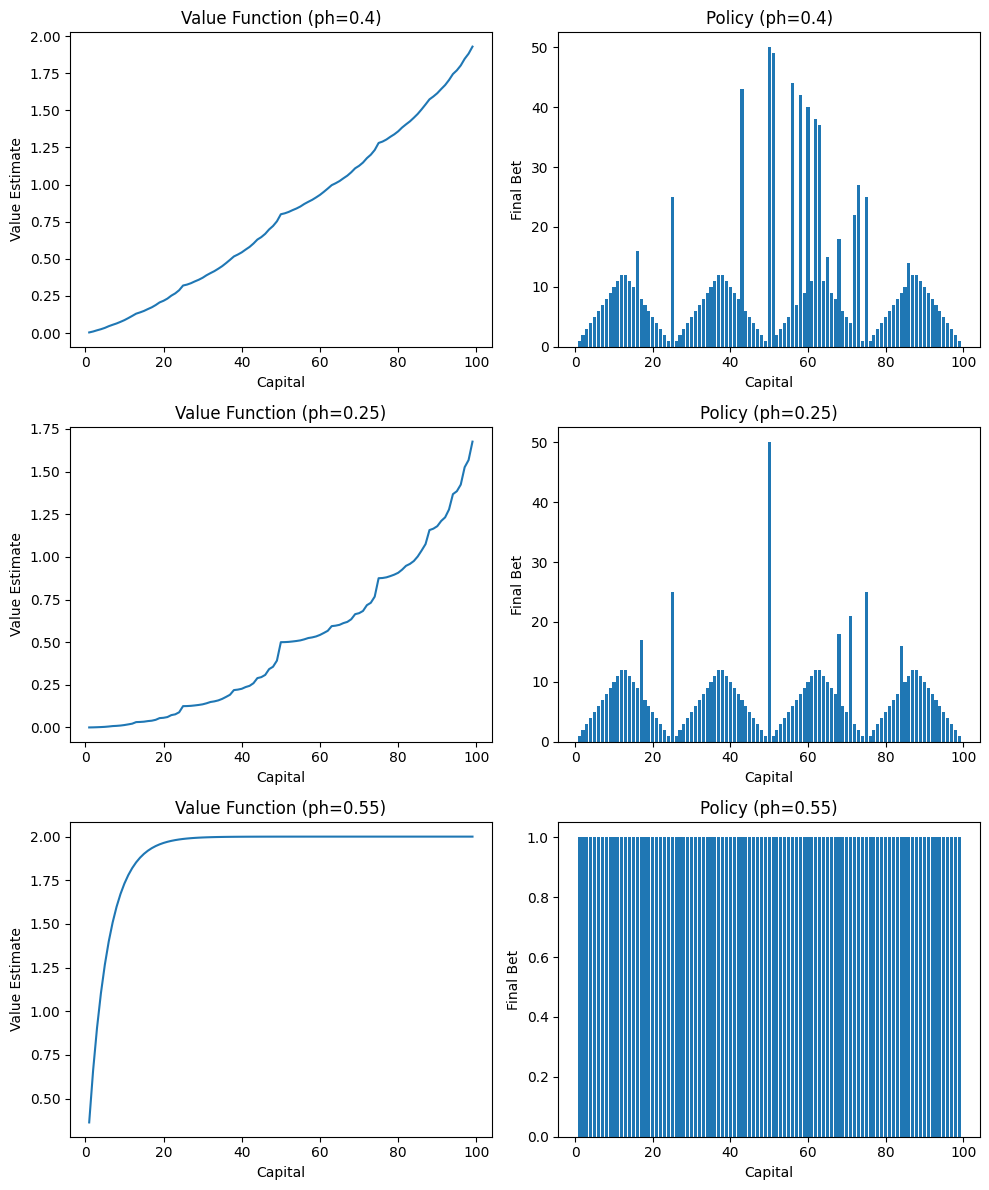

In [2]:
# Plotting the results
plt.figure(figsize=(10, 12))

probs = [0.4, 0.25, 0.55]
states = np.linspace(1, 99, num=99, endpoint=True)

for i, p in enumerate(probs):
    V, pi = train(ph=p)
    
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(states, V)
    plt.title(f'Value Function (ph={p})')
    plt.xlabel('Capital')
    plt.ylabel('Value Estimate')

    plt.subplot(3, 2, 2*i + 2)
    plt.bar(states, pi)
    plt.title(f'Policy (ph={p})')
    plt.xlabel('Capital')
    plt.ylabel('Final Bet')

plt.tight_layout()
plt.show()

## 问题 2：有风网格世界 (Sarsa)

下面的插图是一个标准的网格世界，有开始和目标状态， 但有一个差异：在网格中间有一个向上运行的侧风。 动作是标准的四个── 上，下，右 和 左，但在中间区域， 结果的下一个状态向上移动一个“风”，其强度因列而异。 在每列下方给出风的强度，向上移动的格子数量。 例如，如果你是目标右侧的一个单元格，则左侧的操作会将你带到目标上方的单元格。 这是一个没有折扣的回合任务，在达到目标状态之前回报恒定为 -1。

<img src="images/sarsa.png" style="width:50%; display: block; margin: auto;">

右边的图表显示了将 $\varepsilon$ -贪婪Sarsa应用于此任务的结果， 其中 $\varepsilon=0.1$，$\alpha=0.5$， 并且所有 $s, a$ 初始化价值 $Q(s,a)=0$。 图表的斜率增加表明目标随着时间的推移更快地达到。经过8000个时间步骤，贪婪的策略早已是最优的（它的轨迹显示在图中）； 继续的 $\varepsilon$-贪婪探索将平均回合长度保持在17步左右，比最低值15更多两步。 请注意，蒙特卡罗方法在这里不能轻易使用，因为所有策略都不能保证终止。 如果发现某项策略导致个体保持相同的状态，然后下一回合就永远不会结束。 Sarsa等在线学习方法没有这个问题，因为他们很快就会在这一回合中说这些策略很差，并转而使用其他策略。

练习6.9：带有对角移动的有风网格世界（编程） 重新解决有风的网格世界，假设有八种可能的动作， 包括对角线移动，而不是通常的四种动作。额外行动能使你做得好多少？除了由风引起的第九种动作之外，你能做到更好吗？

In [3]:
from collections import defaultdict

class WindyGridworld():
    def __init__(self, is_eight_action=False, ninth_action=False):
        # origin is defined as left_lower corner. and start from 1
        # namely cols are : 1 2 3 4 5 6 7 8 9 10
        # rows are : 1 2 3 4 5 6 7
        # we start from (1, 4)
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        # we use explicit dictionary instead of function to accelerate training
        self.wind_dict = { 1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
                           6: 1, 7: 2, 8: 2, 9: 1, 10: 0 }

    def step(self, pos, action):
        x, y = pos
        wind = self.wind_dict[x]
        if action == 'left':
            next_state = max(1, x-1), min(y+wind, self.ylimit)
        elif action == 'right':
            next_state = min(self.xlimit, x+1), min(y+wind, self.ylimit)
        elif action == 'up':
            next_state = x, min(y+wind+1, self.ylimit)
        elif action == 'down':
            next_state = x, max(0, min(y+wind-1, self.ylimit))
        else:
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = max(1, x-1), min(y+wind+1, self.ylimit)
                elif action == 'left-down':
                    next_state = max(1, x-1), max(0,min(y+wind-1, self.ylimit))
                elif action == 'right-up':
                    next_state = min(self.xlimit, x+1), min(y+wind+1, self.ylimit)
                elif action == 'right-down':
                    next_state = min(self.xlimit, x+1), max(0,min(y+wind-1, self.ylimit))
                else:
                    if self.ninth_action:
                        if action == 'stay':
                            next_state = x, max(0,min(y+wind, self.ylimit))
                        else:
                            raise ValueError
                    else:
                        raise ValueError
            else:
                raise ValueError
        if next_state == (8, 4):
            return next_state, 0
        else:
            return next_state, -1

In [4]:
from collections import defaultdict

class Agent():
    def __init__(self, alpha=0.5, gamma=1, eps=0.1, is_eight_action=False, ninth_action=False):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(int)
        if not is_eight_action:
            self.action_space= ['left', 'right', 'up', 'down']
        else:
            if ninth_action:
                self.action_space= ['left', 'right', 'up', 'down',
                                'left-up', 'left-down', 'right-up', 'right-down', 'stay']
            else:
                self.action_space= ['left', 'right', 'up', 'down',
                                'left-up', 'left-down', 'right-up', 'right-down']
    def greedy(self, state):
        max_action = self.action_space[0]
        max_Q = self.Q[state, max_action]
        for action in self.action_space:
            if self.Q[state, action] > max_Q:
                max_action = action
                max_Q = self.Q[state, action]
        return max_action

    def e_greedy(self, state):
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            random_action = np.random.choice(self.action_space)
            return random_action

    def update(self, R, state, action, next_state, next_action):
        ########################################
        # Programming 3: Implement Sarsa Update Rule
        # self.Q[state, action] += alpha * (Target - Current)
        # Target = R + gamma * Q[next_state, next_action]
        ########################################
        # Sarsa: Q(s,a) = Q(s,a) + alpha * (R + gamma * Q(s',a') - Q(s,a))
        current_q = self.Q[state, action]
        next_q = self.Q[next_state, next_action]
        target = R + self.gamma * next_q
        
        # 更新Q值
        self.Q[state, action] += self.alpha * (target - current_q)
        ########################################
        ## End of Programming 3
        ########################################

Training 4-action agent...
Training 8-action agent...
Training 9-action agent...


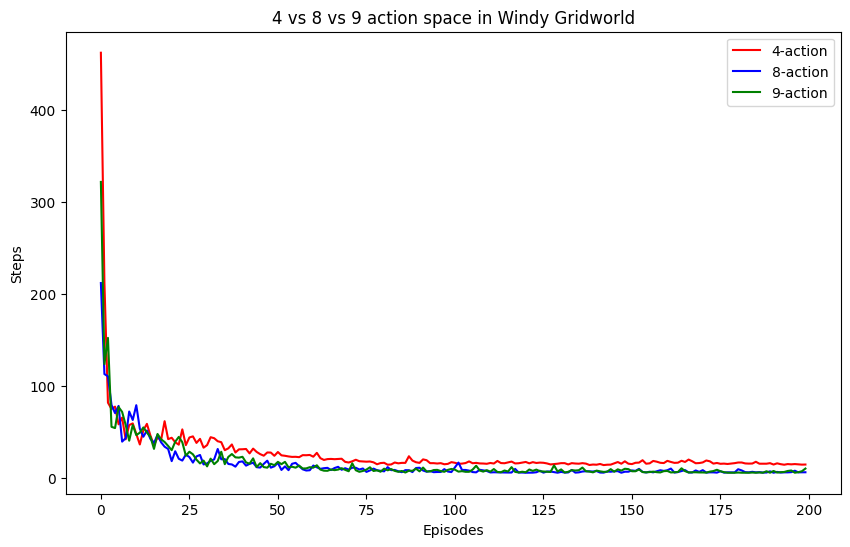

In [5]:
def game(is_eight_action=False, ninth_action=False):
    env = WindyGridworld(is_eight_action=is_eight_action, ninth_action=ninth_action)
    EPISODE = 200
    hist = []
    agent = Agent(is_eight_action=is_eight_action, ninth_action=ninth_action)
    
    for episode in range(EPISODE):
        state = 1, 4
        action = agent.e_greedy(state)
        
        # Training loop
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.e_greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:
                # means next state is terminal
                break
        
        # Evaluation (Test run after each episode)
        state = 1, 4
        action = agent.greedy(state)
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:
                hist.append(step)
                break
    return hist

# Run experiments
print("Training 4-action agent...")
hist_4 = []
for _ in range(10): # Reduce to 10 for speed in homework testing (Solution used 200)
    hist_4.append(game(is_eight_action=False, ninth_action=False))
hist_4 = np.mean(hist_4, axis=0)

print("Training 8-action agent...")
hist_8 = []
for _ in range(10):
    hist_8.append(game(is_eight_action=True, ninth_action=False))
hist_8 = np.mean(hist_8, axis=0)

print("Training 9-action agent...")
hist_9 = []
for _ in range(10):
    hist_9.append(game(is_eight_action=True, ninth_action=True))
hist_9 = np.mean(hist_9, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.title('4 vs 8 vs 9 action space in Windy Gridworld')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.plot(hist_4, '-', c='red', label='4-action')
plt.plot(hist_8, '-', c='blue', label='8-action')
plt.plot(hist_9, '-', c='green', label='9-action')
plt.legend(loc='best')
plt.show()

## 问题 3：Double DQN

接下来的部分我们将介绍Double DQN和Dueling DQN。本部分包含3个代码填空和1个Exercise。

### 简介
DQN算法敲开了用深度神经网络构建Q函数的大门，但是作为先驱性的工作，其本身也存在着一些问题以及一些可以改进的地方，于是在DQN之后学术界涌现出了非常多的改进算法。在本节课程中，我们将介绍其中两个非常著名的算法：Double DQN和Dueling DQN，这两个算法实现简单但能一定程度改善DQN的效果。如果想要了解更加详细的各种DQN改进方法，我们推荐读者阅读论文[1]以及其中的引用文献。

[1] Hessel, Matteo, et al. "[Rainbow: Combining improvements in deep reinforcement learning.](https://arxiv.org/abs/1710.02298)" arXiv preprint arXiv:1710.02298 (2017).

### Double DQN 原理

传统的DQN算法通常会导致对Q值的过高估计。我们可以观察到，传统DQN优化的目标为
$$
r+\gamma \max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)
$$
这个目标由目标网络（参数为$\theta^-$）计算得出，我们还可以将其写成如下形式

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s',  a' \right) \right)
$$

换句话说，max操作实际可以被拆解为两部分，首先选取状态$s'$下的最优动作$a^{*} = \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a' \right)$，接着计算该动作对应的Q值$Q\left(s', a^* \right)$。
当这两部分采用同一套Q网络进行计算时，每次得到的都是神经网络当前估算的所有动作Q值中的最大值。考虑到我们通过神经网络估算的Q值本身在某些时候会产生或正或负的误差，在DQN的更新方式下神经网络会将正误差累积。比如我们考虑一个特殊情形，在状态$s'$下所有动作的Q值均为0，即$Q(s', a_i)=0,\forall i$，此时正确的更新目标应为$r+0=r$。但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差$Q(s', a_j) > 0$，此时我们的更新目标出现了过高估计，$r+\gamma \max Q \geq r$。当我们用DQN的更新公式进行更新时，$Q(s, a)$也就会被过高估计了。同理，我们拿这个$Q(s,a)$来作为更新目标来更新上一步的Q值时，同样会过高估计，并且误差将会逐步累积。


为了解决这一问题，[Double DQN](https://arxiv.org/abs/1509.06461)算法提出利用两个独立训练的神经网络估算$\max_{a'} Q_*(s', a')$。具体做法是将原有的$\max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)$更改为

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta}\left(s',  a' \right) \right)
$$

即我们利用一套神经网络$Q_{\boldsymbol{\theta}}$选取动作，用另一套神经网络$Q_{\boldsymbol{\theta}^{-}}$计算该动作的Q值。这样，就算其中一套神经网络某个动作存在比较严重的过高估计，由于另一套神经网络的存在，这个动作最终使用的Q值不会存在很大的过高估计，从一定程度上解决了这个问题。

在传统的DQN算法中，本来就存在两套Q函数的神经网络——目标网络和训练网络，只不过$\max_{a'} Q_{\theta^-}\left(s', a' \right)$的计算只用到了其中的目标网络，那么我们恰好可以直接将训练网络作为Double DQN算法中的第一套神经网络选取动作，将目标网络作为第二套神经网络计算Q值，这便是Double DQN的主要思想。
由于在DQN算法中我们就将训练网络的参数记为$\theta$，将目标网络的参数记为$\theta^{-}$，这与之前Double DQN中写下的两套神经网络的参数是统一的，我们可以直接写出如下Double DQN的优化目标

$$
r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a'\right)\right)
$$



![Image Name](https://cdn.kesci.com/upload/image/qipg4vdji5.png?imageView2/0/w/960/h/960)


### Double DQN 代码实践
显然，Double DQN与DQN的差别只是在于计算状态$s'$下Q值时动作的选取上：
* DQN的优化目标可以写为$r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a'\right)\right)$，动作的选取依靠目标网络$Q_{\theta^-}$
* Double DQN的优化目标为$r+\gamma Q_{\theta^-}\left(s, \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a' \right)\right)$，动作的选取依靠训练网络$Q_\theta$

所以代码实现可以直接在原DQN的基础上进行，无需做过多修改。

本次采用的环境是[Pendulum](https://gym.openai.com/envs/Pendulum-v0/)，该环境下有一个从随机位置开始的钟摆，钟摆向上保持直立时奖励为0，钟摆在其他位置时奖励为负数，环境本身没有终止状态。环境的状态为钟摆角度的正弦值$\sin \varphi$，余弦值$\cos \varphi$，角速度$\dot\varphi$，动作为对钟摆施加的力矩。每一步会根据当前摆的状态的好坏给予不同的奖励,该环境的奖励函数为$-(\varphi^2+0.1\dot\varphi^2+0.001a^2)$。200步后自动结束游戏。在此环境下我们可以验证DQN对于Q值的过高估计——该环境下Q值的最大估计应为0(钟摆向上保持竖直时能选取的最大Q值)，Q值出现大于0的情况则说明出现了过高估计。
**注：由于Pendulum-v1环境的动作为一个代表力矩，在[-2,2]范围内的连续值，为了方便起见，我们采用离散化动作的方法。如下面的代码中我们将连续的动作空间离散为11个动作。动作0，1，..., 9, 10分别代表力矩为-2， -1.6， ..., 1.6, 2**

该环境的状态有三个参数：

标号 | 名称  | 最小值 | 最大值  
----|--------------|-----|----   
0   | $\cos \varphi$  | -1.0| 1.0
1   | $\sin \varphi$   | -1.0| 1.0
2   | $\dot\varphi$  | -8.0| 8.0

该环境只有一类动作（连续动作）：

标号 | 动作  | 最小值 | 最大值  
----|--------------|-----|----   
0   | 力矩 | -2.0| 2.0



![Pendulum](https://cdn.kesci.com/upload/image/qfoepa3n0z.gif?imageView2/0/w/960/h/960)

In [7]:
import sys  
# !{sys.executable} -m pip install "numpy<2.0"
# !{sys.executable} -m pip install gym
# !{sys.executable} -m pip install tqdm
# !{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !{sys.executable} -m pip install -U matplotlib
    
import math
import random
import time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Normal
from tqdm import tqdm

import matplotlib.pyplot as plt

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

In [9]:
gamma = 0.9
# 注意此时的训练函数多了一个isDoubleDQN的参数
def learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    with torch.no_grad():
        state = torch.FloatTensor(np.float32(state)).to(device)
        next_state = torch.FloatTensor(np.float32(next_state)).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        done = torch.FloatTensor(done).to(device)

    q_values = current_model(state)
    next_q_values = current_model(next_state)
    next_q_values_target = target_model(next_state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # the only difference between Double DQN and DQN
    ########################################
    # Programming 4: 计算DQN与DoubleDQN算法的更新目标，并更新网络
    ########################################
    if isDoubleDQN:
        # Double DQN: 使用当前网络选择动作，目标网络评估价值
        next_actions = next_q_values.max(1)[1]  # 当前网络选择最优动作
        next_q_values_target_max = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        expected_q_value = reward + gamma * next_q_values_target_max * (1 - done)
    else:
        # 标准DQN: 使用目标网络选择动作和评估价值
        next_q_values_target_max = next_q_values_target.max(1)[0]
        expected_q_value = reward + gamma * next_q_values_target_max * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ########################################
    ## End of Programming 4
    ########################################

In [10]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
        
    def __len__(self):
        return len(self.buffer)

In [11]:
class DQN_base(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        raise NotImplementedError

    def act(self, state, epsilon, discrete_action_n):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
                q_value = self.forward(state)
                action = q_value.max(1).indices.item()
        else:
            action = random.randrange(discrete_action_n)
        return action

In [12]:
class DQN(DQN_base):
    def __init__(self, input_n, num_actions):
        super(DQN, self).__init__()

        self.input_n = input_n
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(self.input_n, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.num_actions)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [13]:
discrete_action_n = 11  # 使用离散的动作空间 [0, discrete_action_n-1]
env_id = "Pendulum-v1"
env = gym.make(env_id)
input_n = env.observation_space.shape[0]
action_lowbound = env.action_space.low[0]
action_upbound = env.action_space.high[0]
# discrete action to continuous action
def faction(discrete_n):
    return action_lowbound + (discrete_n / (discrete_action_n - 1)) * (action_upbound - action_lowbound)

In [14]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [15]:
def plotMaxQ(max_Qs):
    plt.xlabel("Frame")
    plt.ylabel("Q value")
    plt.plot(max_Qs)
    plt.show()
    
def plotReward(all_rewards):
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(all_rewards)
    plt.show()

In [16]:
def smooth(array, l=10):
    return [np.mean(array[i-l+1:i+1]) for i in range(len(array))]

def train(isDoubleDQN: bool=False, isDuelingDQN: bool=False, DQN: DQN_base=None, DuelingDQN: DQN_base=None):
    # 超参数定义
    replay_initial = 3000
    replay_buffer_size = 3000
    replay_buffer = ReplayBuffer(replay_buffer_size)
        
    num_frames = 50000
    batch_size = 32
        
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 1500
    epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
            -1. * frame_idx / epsilon_decay)
    update_target_step = 200

    def maxQ(model, state):
        with torch.no_grad():
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = model.forward(state)
            max_q_value = q_value.max(1).values.item()
        return max_q_value
    
    if isDuelingDQN:
        current_model = DuelingDQN(input_n, discrete_action_n).to(device)
        target_model = DuelingDQN(input_n, discrete_action_n).to(device)
    else:
        current_model = DQN(input_n, discrete_action_n).to(device)
        target_model = DQN(input_n, discrete_action_n).to(device)
    update_target(current_model, target_model)
    
    optimizer = optim.Adam(current_model.parameters(), lr=0.005)
    
    max_Qs = []
    now_Q = 0
    all_rewards = []
    episode_reward = 0
    episode = 0

    state = env.reset()[0]
    random.seed(1)
    for frame_idx in tqdm(range(1, num_frames + 1)):
        time.process_time()
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon, discrete_action_n)
    
        now_Q = maxQ(current_model, state) * 0.01 + now_Q * 0.99 # to make the curve more smooth
        max_Qs.append(now_Q)
    
        next_state, reward, terminated, truncated, _ = env.step(np.array([faction(action)]))
        done = terminated or truncated
        reward /= 10
        replay_buffer.push(state, action, reward, next_state, done)
        
        episode_reward += reward
        state = next_state
        if done:
            state = env.reset()[0]
            all_rewards.append(episode_reward)
            episode_reward = 0
            episode += 1
    
        if len(replay_buffer) >= replay_initial:
            learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN=isDoubleDQN)
    
        if frame_idx % update_target_step == 0:
            update_target(current_model, target_model)
        
    return max_Qs, all_rewards

以下训练预计时间：1分钟。

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [02:31<00:00, 329.10it/s]


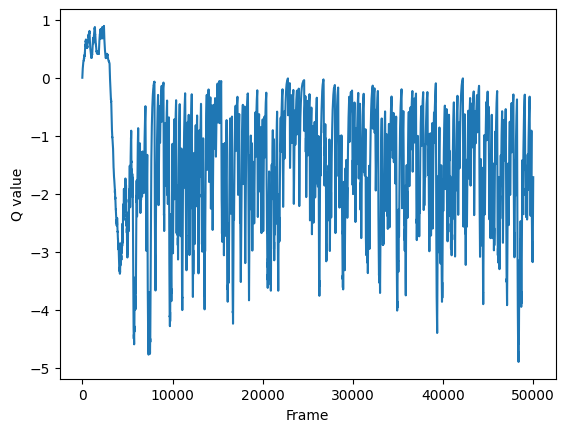

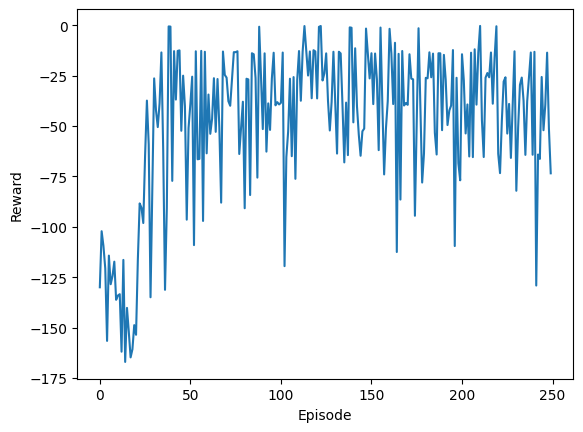

In [18]:
max_Qs_doubleDQN, returns_doubleDQN = train(isDoubleDQN = True, DQN=DQN)
plotMaxQ(max_Qs_doubleDQN)
plotReward(returns_doubleDQN)

100%|██████████| 50000/50000 [02:29<00:00, 333.91it/s]


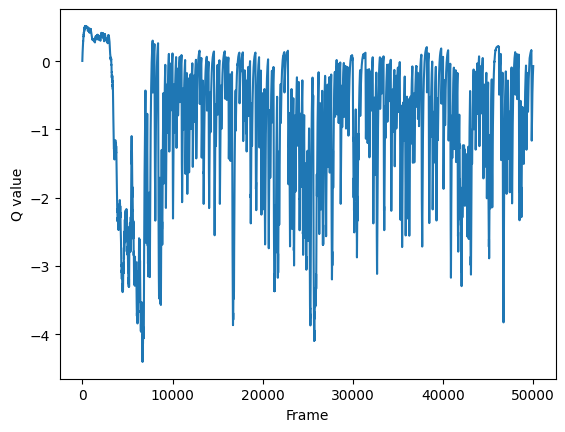

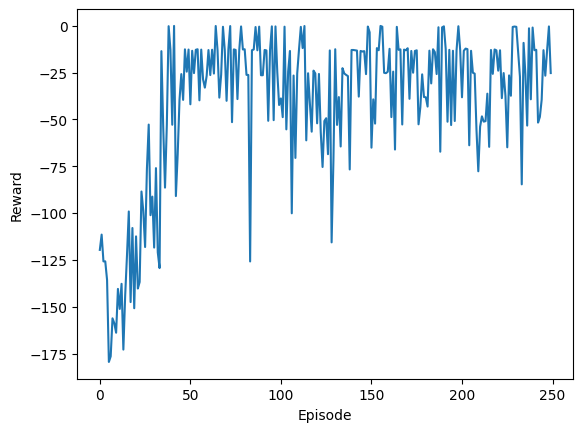

In [20]:
max_Qs_regularDQN, returns_regularDQN = train(isDoubleDQN = False, DQN=DQN)
plotMaxQ(max_Qs_regularDQN)
plotReward(returns_regularDQN)

In [21]:
def compareMaxQ(Q1, Q2, labels=["Double DQN", "DQN"]):
    Q1, Q2 = smooth(Q1,l=50), smooth(Q2, l=50)
    plt.xlabel("frame")
    plt.ylabel("Q value")
    plt.plot(Q1)
    plt.plot(Q2)
    plt.legend(labels)
    plt.show()
    
def compareReturn(reward1, reward2, labels=["Double DQN", "DQN"]):
    reward1, reward2 = smooth(reward1), smooth(reward2)
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    minEpisode = min(len(reward1),len(reward2))
    plt.plot(reward1[:minEpisode])
    plt.plot(reward2[:minEpisode])
    plt.legend(labels)
    plt.show()

/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide


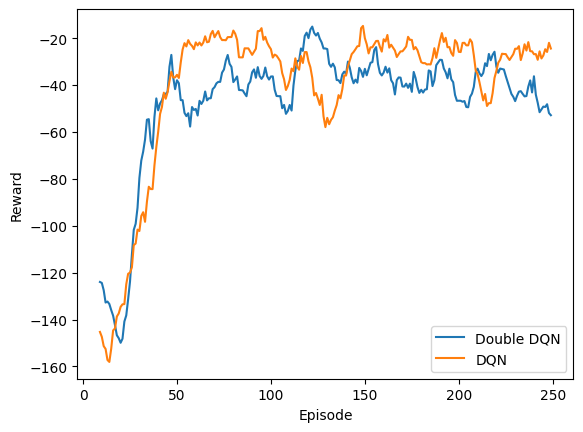

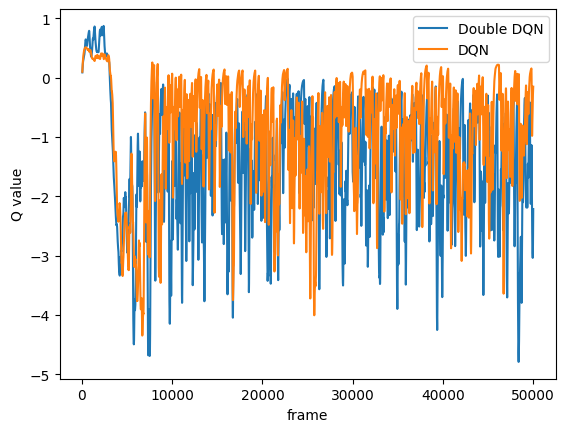

In [22]:
compareReturn(returns_doubleDQN, returns_regularDQN)
compareMaxQ(max_Qs_doubleDQN, max_Qs_regularDQN)

参考结果如下:

<img src="images/DoubleDQN_DQN_1.png" style="width:50%; display: block; margin: auto;">

<img src="images/DoubleDQN_DQN_2.png" style="width:50%; display: block; margin: auto;">


我们可以发现，相比于Double DQN，普通的DQN算法对于Q值的估计要略微高一些。

## 问题 4：Dueling DQN (Bonus)

[Dueling DQN](https://arxiv.org/abs/1511.06581)是另一种DQN的改进算法。它在传统DQN的基础上只进行了稍稍改动，但却能大幅提升DQN的表现。在强化学习中，我们将状态动作价值函数减去状态函数定义为优势函数，即$A(s,a) = Q(s,a)-V(s)$。在同一个状态下，所有动作的优势值之和为0，因为所有动作的动作价值的平均就是这个状态的状态价值。据此，在Dueling DQN中，Q网络被建模为：

$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)
$$

其中$V(s ; \theta, \beta)$为状态价值函数，而$A(s, a ; \theta, \alpha)$则为该状态下采取不同动作的优势函数，表征的是采取不同动作的差异性。$\theta$是状态价值函数和优势函数共享的网络参数，一般为神经网络用来提取特征的前几层。而$\alpha$和$\beta$为两者各自的参数。在这样的建模下我们不再让神经网络直接输出Q值，而是训练神经网络的两部分分别输出价值函数和优势函数，再求和得到Q值。DQN和Dueling DQN的网络结构图区别如下：

![DQN与Dueling DQN网络结构的区别](https://cdn.kesci.com/upload/image/qfmiegdc53.png?imageView2/0/w/320/h/320)

对于上述Dueling DQN中的公式$Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)$，它存在对于$A$值和$V$值建模不唯一性的问题（比如对于同样的$Q$值，如果将$V$值加上任意大小的常数$C$，再将所有$A$值减去$C$，则我们得到的$Q$值依然不变，这就给训练造成了不稳定）。为了解决这一问题，原论文将强制将优势函数在实际行为的输出调整为$0$，即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+\left(A(s, a ; \theta, \alpha)-\max _{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
此时可以确保$V$值建模的唯一性。
而在实际实现过程中，我们通常将优势函数在所有动作的输出期望设为$0$,即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+ 
\left(A(s, a ; \theta, \alpha)-\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
这样可以提高稳定性。在下面的代码实现中，我们将采取此种方式。

**Exercise (Bonus).**  Dueling DQN从单一的网络架构中分离出价值函数和优势函数，这种分离的直观解释是什么。并请解释为何Dueling DQN在一些环境中的表现会好于DQN。


Dueling DQN将Q函数分解为状态价值V(s)和优势函数A(s,a)，即Q(s,a) = V(s) + A(s,a)

- 状态函数代表当前状态 s 的情况下的状态值
- 优势函数代表在某个状态下，选择某个动作相对于平均水平的额外收益

使用优势函数分离因为可能某些状态本身就是一个高价值状态，这与当前状态有关而与选择的动作无关。例如，在将军的状态下，这个状态本身就是高价值的，但是此时模型需要最大化优势函数，例如选择"将死"的动作。

相比于 DQN 的优势：

- 通过分离，网络可以更准确地学习到哪些状态是好的，而不需要在每个状态下都评估所有动作
- 对于未访问过的动作，网络仍能通过状态价值给出合理的估计，标准DQN需要对每个状态-动作对都进行估计，而Dueling DQN可以通过状态价值进行泛化


### Dueling DQN 代码实践
Dueling DQN与DQN相比的差异只是在网络结构上，大部分代码依然可以继续沿用，注意进行下方代码前要运行上方定义超参数的代码

In [23]:
class DuelingDQN(DQN_base):
    def __init__(self, input_n, num_actions):
        super().__init__()

        self.input_n = input_n
        self.num_actions = num_actions
        
        # the difference
        ########################################
        ## Programming 5: 定义Dueling DQN的网络结构，建议参考上方DQN的网络结构所使用的超参数
        ########################################
        # 共享的特征提取层
        self.feature_layer = nn.Sequential(
            nn.Linear(self.input_n, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU()
        )
        
        # 价值函数流 V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 1)  # 输出单个状态价值
        )
        
        # 优势函数流 A(s,a)
        self.advantage_stream = nn.Sequential(
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.num_actions)  # 输出每个动作的优势值
        )
        ########################################
        ## End of Programming 5
        ########################################

    def forward(self, x):
        # the difference
        ########################################
        ## Programming 6: 实现Dueling DQN输出Q的方法
        ########################################
        # 提取共享特征
        features = self.feature_layer(x)
        
        # 计算状态价值和优势值
        value = self.value_stream(features)  # shape: [batch_size, 1]
        advantage = self.advantage_stream(features)  # shape: [batch_size, num_actions]
        
        # 使用平均值的组合方式：Q(s,a) = V(s) + A(s,a) - mean(A(s,a'))
        advantage_mean = advantage.mean(dim=1, keepdim=True)  # shape: [batch_size, 1]
        q_values = value + advantage - advantage_mean  # shape: [batch_size, num_actions]
        
        return q_values
        ########################################
        ## End of Programming 6
        ########################################

以下训练预计时间：2分钟。

In [24]:
_, returns_duelingDQN = train(isDoubleDQN=False, isDuelingDQN=True, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 50000/50000 [03:54<00:00, 213.10it/s]


In [26]:
_, returns_DQN = train(isDoubleDQN=False, isDuelingDQN=False, DQN=DQN, DuelingDQN=DuelingDQN)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [02:32<00:00, 328.89it/s]


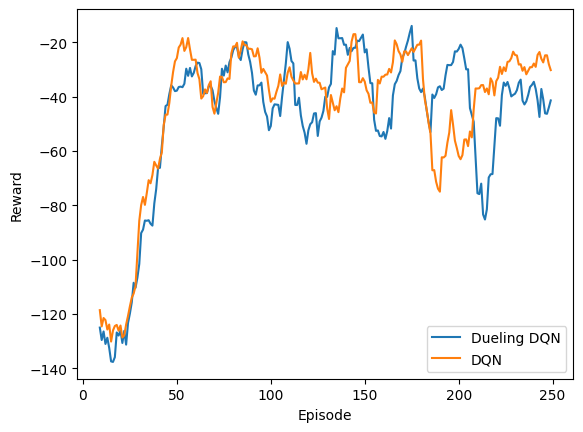

In [27]:
compareReturn(returns_duelingDQN, returns_DQN, labels=['Dueling DQN', 'DQN'])

通过曲线可以看出，相比于朴素的DQN，Dueling DQN相比于DQN在多个动作选择下的学习显得更加稳定一些。但是由于该环境较为简单，动作空间也不大，所以优势并不明显。

参考结果：

![Image Name](images/dueling_dqn.png)


### 总结
在传统的DQN基础上，有两种非常容易实现的变式——Double DQN和Dueling DQN，Double DQN解决了DQN中对Q值的过高估计，而Dueling DQN能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。

### 扩展阅读： 对Q值过高估计的定量分析
我们可以对Q值的过估计做一个简化的定量分析。假设在状态$s$下所有动作的期望回报均无差异，即$Q_*(s,a) = V_*(s)$（此情形是为了定量分析所简化的情形，实际上不同动作的期望回报通常会存在差异）。假设神经网络估算误差$Q_{\theta^-}(s, a)-V_{*}$服从$[-1,1]$之间的均匀独立同分布。假设动作空间大小为$m$，那么对于任意状态$s$我们有
$$
\mathbb{E}\left[\max _{a} Q_{\theta^-}(s, a)- \max_{a'} Q_{*}(s,a')\right]=\frac{m-1}{m+1}
$$
**证明：**
我们将估算误差记为$\epsilon_{a}=Q_{\theta^-}(s, a)-\max_{a'}Q_{*}(s, a')$，由于估算误差对于不同的动作是独立的，我们有
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) =\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right)
\end{aligned}
$$
$P(\epsilon_a \leq x)$是$\epsilon_a$的累积分布函数（CDF）,它可以具体被写为
$$
P\left(\epsilon_{a} \leq x\right)=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\frac{1+x}{2} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
$$
因此，我们有关于$\max_a \epsilon_a$的累积密度函数(CDF)
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) &=\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right) \\
&=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\left(\frac{1+x}{2}\right)^{m} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
\end{aligned}
$$
最后我们可以得到
$$
\begin{aligned}
\mathbb{E}\left[\max _{a} \epsilon_{a}\right] &=\int_{-1}^{1} x \frac{\mathrm{d}}{\mathrm{d} x} P\left(\max _{a} \epsilon_{a} \leq x \right) \mathrm{d} x \\
&=\left[\left(\frac{x+1}{2}\right)^{m} \frac{m x-1}{m+1}\right]_{-1}^{1} \\
&=\frac{m-1}{m+1}
\end{aligned}
$$
虽然这一分析简化了实际环境，但它正确刻画了Q值过高估计的一些性质，比如Q值的过高估计随动作数目$m$的增加而增加，换而言之，在动作选择数更多的环境中Q值的过高估计会更严重。